In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import fsolve
import os
import imageio

In [5]:
#функция для отрисвки области покрытия дрона
#нужно указать центр окружности = (x,y) и радиус окружности(область покрытия) = R
def plot_drone_round(x,y,r):
    angles = np.linspace(0,2*np.pi,100)
    x_cir = x + r*np.cos(angles)
    y_cir = y + r*np.sin(angles)
    plt.plot(x_cir,y_cir,color = 'green')

In [6]:
# функция отрисовки спиральной траетории
# a - коэфициент растояние между ветками
# b - коэфициент cмещения спирали
# n*pi -  угол поворота спирали
# iterations -  чем больше тем точнее рисует линию
def plot_line(a,b,n,iterations):
    angles = np.linspace(0,n*np.pi,iterations)
    x_cir=np.abs((a/(2*np.pi)*angles))*np.cos(angles)+b
    y_cir=np.abs((a/(2*np.pi)*angles))*np.sin(angles)+b
    #scatter - если хотим посмотреть точечный график
    plt.plot(x_cir,y_cir,linestyle = '--')

In [7]:
# функция  необходимая для нахождения  длины спирали
def f(x,a):
    f1 = a*np.cos(x)/(2*np.pi) -a*x*np.sin(x)/(2*np.pi)
    f2 = a*np.sin(x)/(2*np.pi) +a*x*np.cos(x)/(2*np.pi)
    return np.sqrt(f1**2 + f2**2)


In [8]:
# функция  необходимая для нахождения phi_i+1 (движения от 0*pi до n*pi)
def eqt1(x,a,phi, vd):
    return (4*np.pi*vd/a) + np.log(np.sqrt(phi**2 +1)+phi) + phi*np.sqrt(phi**2 +1) - x*np.sqrt(x**2+1)-np.log(np.sqrt(x**2+1)+x)

In [9]:
# функция  необходимая для нахождения phi_i+1 (движения от n*pi до 0*pi)
def eqt2(x,a,phi, vd):
    return -(4*np.pi*vd/a) - np.log(np.sqrt(x**2 +1)+x) - x*np.sqrt(x**2 +1) + phi*np.sqrt(phi**2+1)+np.log(np.sqrt(phi**2+1)+phi)

In [10]:
# функция для расчета растояния между дроном и пользователем (между двимя точками)
def distance(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

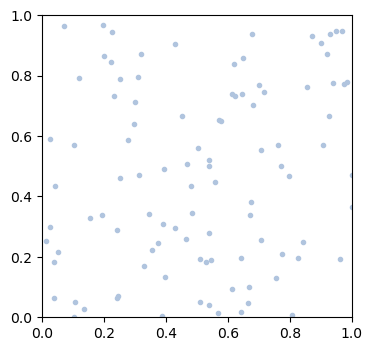

In [11]:
N = 100 # число пользователей
# Задаем координаты N пользователей (область потрулирования Ω = равномерное распределение [a_ravn,b_ravn])
a_ravn = 0
b_ravn = 1
x_user=np.random.uniform(a_ravn,b_ravn,N)
y_user=np.random.uniform(a_ravn,b_ravn,N)

# Отрисовываем расположение пользователей на области
plt.figure(dpi=100,figsize=(4,4))
plt.plot(x_user,y_user,'.',color='LightSteelBlue')
plt.xlim(a_ravn,b_ravn)
plt.ylim(a_ravn,b_ravn)
plt.show()

In [12]:
R = 0.1 # радиус покрытия дрона в км 

# задаем парметры спирали
a=2*R
b=b_ravn/2
n = (b*1-R)/a*2

drone_speed = 5*10**-3 # скорость дрона в метрах

traektory_len, err = integrate.quad(f, 0, n*np.pi,args=(a))# вычисление длины траетории

iterations = round(traektory_len/drone_speed) # примерное  колличество итераций 

In [13]:
phi =[0]
S = 0
working_mode = 0
residual_distance = 0
time_model = 1000
print ('_____________режим работы 1______________________')

for i in range(time_model):
    if working_mode == 0:
        
        x_sol = fsolve(eqt1,args=(a,phi[-1],drone_speed),x0=0)

        print("Solution: ",x_sol)
        phi.append(x_sol[0])

        v, err = integrate.quad(f, phi[-2], phi[-1],args=(a))
        print("distanse: ",v)
        S += v

        if S>traektory_len :
            phi[-1] = n*np.pi
            residual_distance = S-traektory_len
            print("residual distance = ",residual_distance)
            x_sol = fsolve(eqt2,args=(a,phi[-1],residual_distance),x0=0)
            print("n*pi: ",np.pi*n)
            print("Solution: ",x_sol)
            v, err = integrate.quad(f, x_sol, phi[-2],args=(a))
            print("distanse: ",v)
            phi[-1] = x_sol[0]
            S = traektory_len -v
            working_mode = 1
            print ('_____________режим работы 2______________________')
    
    if working_mode == 1:
        
        x_sol = fsolve(eqt2,args=(a,phi[-1],drone_speed),x0=0)

        print("Solution: ",x_sol)
        phi.append(x_sol[0])

        v, err = integrate.quad(f, phi[-1], phi[-2],args=(a))
        print("distanse: ",v)
        S -= v

        if S < 0  :
            phi[-1] = 0*np.pi
            residual_distance = 0-S
            print("residual distance = ",residual_distance)
            x_sol = fsolve(eqt1,args=(a,phi[-1],residual_distance),x0=0)
            print("0*pi: ",np.pi*0)
            print("Solution: ",x_sol)
            v, err = integrate.quad(f, phi[-1], x_sol,args=(a))
            print("distanse: ",v)
            phi[-1] = x_sol[0]
            S = +v
            working_mode = 0
            print ('_____________режим работы 1______________________')

_____________режим работы 1______________________
Solution:  [0.1564438]
distanse:  0.005000000000000006
Solution:  [0.30929629]
distanse:  0.004999999999999996
Solution:  [0.4559048]
distanse:  0.004999999999999986
Solution:  [0.59489129]
distanse:  0.004999999999999996
Solution:  [0.72592147]
distanse:  0.005
Solution:  [0.8492927]
distanse:  0.004999999999999997
Solution:  [0.96559773]
distanse:  0.004999999999999842
Solution:  [1.07552067]
distanse:  0.004999999999999999
Solution:  [1.17973353]
distanse:  0.0049999999999999975
Solution:  [1.27885197]
distanse:  0.0050000000000000044
Solution:  [1.37342149]
distanse:  0.004999999999999992
Solution:  [1.46391785]
distanse:  0.005000000000000007
Solution:  [1.55075318]
distanse:  0.0050000000000000435
Solution:  [1.63428397]
distanse:  0.00500000000000023
Solution:  [1.71481894]
distanse:  0.0050000000000012925
Solution:  [1.79262627]
distanse:  0.0050000000000000105
Solution:  [1.86793981]
distanse:  0.005000000000000019
Solution:  [

Solution:  [9.99310299]
distanse:  0.0049999999999998075
Solution:  [10.00873158]
distanse:  0.004999999999999612
Solution:  [10.02433604]
distanse:  0.004999999999999666
Solution:  [10.03991649]
distanse:  0.004999999999999841
Solution:  [10.05547303]
distanse:  0.005000000000000229
Solution:  [10.07100578]
distanse:  0.005000000000000126
Solution:  [10.08651484]
distanse:  0.00499999999999977
Solution:  [10.10200033]
distanse:  0.004999999999999739
Solution:  [10.11746234]
distanse:  0.004999999999999665
Solution:  [10.13290099]
distanse:  0.004999999999999783
Solution:  [10.14831637]
distanse:  0.005000000000000133
Solution:  [10.1637086]
distanse:  0.005000000000000294
Solution:  [10.17907778]
distanse:  0.005000000000000255
Solution:  [10.194424]
distanse:  0.005000000000000129
Solution:  [10.20974738]
distanse:  0.004999999999999861
Solution:  [10.22504802]
distanse:  0.0050000000000001025
Solution:  [10.24032601]
distanse:  0.005000000000000219
Solution:  [10.25558145]
distanse:

distanse:  0.0050000000000003375
Solution:  [11.09113416]
distanse:  0.004999999999999433
Solution:  [11.07701983]
distanse:  0.004999999999999436
Solution:  [11.06288765]
distanse:  0.0049999999999998535
Solution:  [11.04873754]
distanse:  0.00500000000000016
Solution:  [11.03456943]
distanse:  0.0049999999999999125
Solution:  [11.02038325]
distanse:  0.004999999999999868
Solution:  [11.00617894]
distanse:  0.005000000000000417
Solution:  [10.99195642]
distanse:  0.005000000000000412
Solution:  [10.97771563]
distanse:  0.005000000000000166
Solution:  [10.96345649]
distanse:  0.0050000000000004746
Solution:  [10.94917894]
distanse:  0.005000000000000164
Solution:  [10.9348829]
distanse:  0.0050000000000002725
Solution:  [10.9205683]
distanse:  0.004999999999999893
Solution:  [10.90623506]
distanse:  0.004999999999999896
Solution:  [10.89188313]
distanse:  0.004999999999999533
Solution:  [10.87751241]
distanse:  0.0049999999999996644
Solution:  [10.86312285]
distanse:  0.005000000000000

Solution:  [5.65242817]
distanse:  0.004999999999999931
Solution:  [5.62499882]
distanse:  0.005000000000000049
Solution:  [5.5974392]
distanse:  0.00500000000000015
Solution:  [5.56974745]
distanse:  0.004999999999999935
Solution:  [5.54192168]
distanse:  0.00500000000000001
Solution:  [5.51395994]
distanse:  0.005000000000000014
Solution:  [5.48586024]
distanse:  0.005000000000000025
Solution:  [5.45762053]
distanse:  0.0050000000000001285
Solution:  [5.42923874]
distanse:  0.0050000000000000626
Solution:  [5.40071272]
distanse:  0.004999999999999931
Solution:  [5.37204027]
distanse:  0.005000000000035405
Solution:  [5.34321914]
distanse:  0.005000000000027193
Solution:  [5.31424703]
distanse:  0.005000000000020678
Solution:  [5.28512156]
distanse:  0.005000000000015742
Solution:  [5.2558403]
distanse:  0.00500000000001189
Solution:  [5.22640075]
distanse:  0.005000000000008721
Solution:  [5.19680035]
distanse:  0.005000000000006475
Solution:  [5.16703648]
distanse:  0.00500000000000

In [14]:
# Перезаписываем данные, согласуя их со скоростью дрона
angles= np.array(phi)
# Массивы для расчета длины кривой(спирали)
X=(a/(2*np.pi)*angles)*np.cos(angles)+b
Y=(a/(2*np.pi)*angles)*np.sin(angles)+b

In [15]:
# блок для вычисления и заполнения массива покрытых пользователей в момент времени i
covered_users=[] # задаем список, который будет хранить количство покрытых пользователей в момент времни i
sir_users=np.array([0]*N) # задаем список, который будет вычислять SIR i - ого пользовате
for j in range (len(X)):
    covered = 0
    for i in range (len(x_user)):
        if distance(x_user[i],y_user[i],X[j],Y[j])<=R: # проверяем условие обслуживания
            covered +=1
            sir_users[i] += 1
    covered_users.append(covered)

Text(0.5, 1.0, 'Cпиральная траетория')

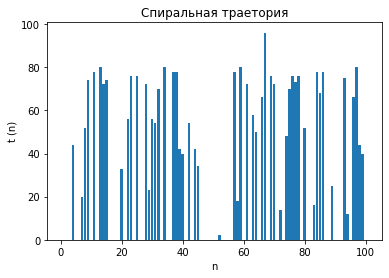

In [16]:
plt.bar([i for i in range(1,101)],sir_users)
plt.xlabel('n')
plt.ylabel('t (n)')
plt.title('Cпиральная траетория')

Text(0.5, 1.0, 'Cпиральная траетория')

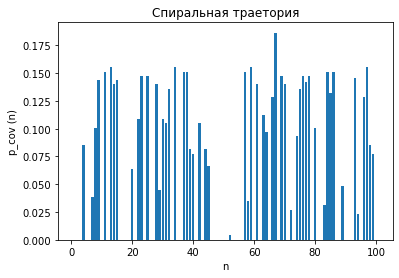

In [17]:
plt.bar([i for i in range(1,101)],sir_users/iterations)
plt.xlabel('n')
plt.ylabel('p_cov (n)')
plt.title('Cпиральная траетория')

mean = 3.1107784431137726


Text(0.5, 1.0, 'Cпиральная траетория')

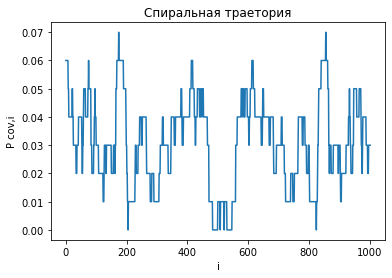

In [18]:
covered_users_copy = np.copy(covered_users)
covered_users_copy = [i/N for i in covered_users_copy]
plt.plot(range(len(X)),covered_users_copy) # график числа покрытых пользователей
mean = np.mean(covered_users) # математическео ожидание покрытых пользователей
print(f'mean = {mean}')
plt.xlabel('i')
plt.ylabel('P cov,i')
plt.title('Cпиральная траетория')

In [19]:
sir_users/iterations

array([0.        , 0.        , 0.        , 0.08543689, 0.        ,
       0.        , 0.03883495, 0.10097087, 0.14368932, 0.        ,
       0.15145631, 0.        , 0.15533981, 0.13980583, 0.14368932,
       0.        , 0.        , 0.        , 0.        , 0.06407767,
       0.        , 0.10873786, 0.14757282, 0.        , 0.14757282,
       0.        , 0.        , 0.13980583, 0.04466019, 0.10873786,
       0.10485437, 0.13592233, 0.        , 0.15533981, 0.        ,
       0.        , 0.15145631, 0.15145631, 0.0815534 , 0.0776699 ,
       0.        , 0.10485437, 0.        , 0.0815534 , 0.06601942,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0038835 , 0.        , 0.        , 0.        ,
       0.        , 0.15145631, 0.03495146, 0.15533981, 0.        ,
       0.13980583, 0.        , 0.11262136, 0.09708738, 0.        ,
       0.12815534, 0.18640777, 0.        , 0.14757282, 0.13980583,
       0.        , 0.02718447, 0.        , 0.09320388, 0.13592

Выбирете момент времени от 0 до 1001 : 450


Text(0.5, 1.0, 'Time: 450')

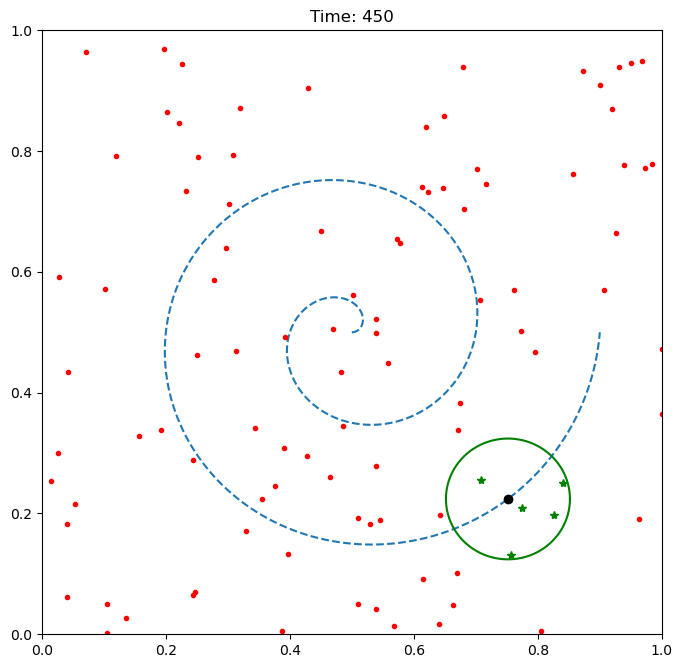

In [20]:
moment = int(input(f'Выбирете момент времени от 0 до {len(X)-1} : '))
plt.figure(dpi=100,figsize=(8,8))
#рисуем траеторию
plot_line(a,b,n,2000)
#рисуем точку доступа - дрон 
plt.plot(X[moment],Y[moment],'o',color='black')
#рисуем область покрытия дрона
plot_drone_round(X[moment],Y[moment],R)
covered = 0
for i in range (len(x_user)):
    if distance(x_user[i],y_user[i],X[moment],Y[moment])<=R:
        plt.plot(x_user[i],y_user[i],'*',color='green') 
        covered +=1
    else:
        plt.plot(x_user[i],y_user[i],'.',color='red')
plt.xlim(0,1) #прописать границы области моделирования в ручную
plt.ylim(0,1) #прописать границы области моделирования в ручную
plt.title('Time: '+str(moment) )

In [63]:
#!!!!!!!!!!
#!!!!!!!!!!
# процесс создания гиф изображения
# не выполнять без необходимости, т.к.ваш ПК будет думать минут 10 - 20 

with imageio.get_writer('mygif.gif', mode='I') as writer:
    for j in range (len(X)):
        abc=plt.figure(dpi=100,figsize=(8,8))
        #рисуем траеторию
        plot_line(a,b,n,iterations)
        #рисуем точку доступа - дрон 
        plt.plot(X[j],Y[j],'o',color='black')
        #рисуем область покрытия дрона
        plot_drone_round(X[j],Y[j],R)
        covered = 0
        for i in range (len(x_user)):
            if distance(x_user[i],y_user[i],X[j],Y[j])<=R:
                plt.plot(x_user[i],y_user[i],'.',color='green') 
                covered +=1
            else:
                plt.plot(x_user[i],y_user[i],'.',color='red')
        plt.xlim(0,1) #прописать границы области моделирования в ручную
        plt.ylim(0,1) #прописать границы области моделирования в ручную
        plt.title('Time: '+str(j) )
        abc.savefig(str(j)+'saved_figure.png') 
        screen_name =str(j)+'saved_figure.png'
        plt.close()
            

        image = imageio.imread(screen_name)
        writer.append_data(image)
        
        os.remove(screen_name)
        
        print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [62]:
#!!!!!!!!!!
#!!!!!!!!!!
# процесс создания гиф изображения с использование большого числа оперативной памяти
# не выполнять без необходимости, т.к.ваш ПК будет думать минут 10 - 20 
covered_users=[]
screen_name=[]
for j in range (len(X)):
    abc=plt.figure(dpi=100,figsize=(8,8))
    #рисуем траеторию
    plot_line(a,b,n,iterations)
    #рисуем точку доступа - дрон 
    plt.plot(X[j],Y[j],'o',color='black')
    #рисуем область покрытия дрона
    plot_drone_round(X[j],Y[j],R)
    covered = 0
    for i in range (len(x_user)):
        if distance(x_user[i],y_user[i],X[j],Y[j])<=R:
            plt.plot(x_user[i],y_user[i],'.',color='green') 
            covered +=1
        else:
            plt.plot(x_user[i],y_user[i],'.',color='red')
    plt.xlim(0,1) #прописать границы области моделирования в ручную
    plt.ylim(0,1) #прописать границы области моделирования в ручную
    plt.title('Time: '+str(j) )
    abc.savefig(str(j)+'saved_figure.png') 
    screen_name.append(str(j)+'saved_figure.png')
    plt.close()
    print(j)
    
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in screen_name:
        image = imageio.imread(filename)
        writer.append_data(image)
        print(filename)
                       

for filename in screen_name:
    os.remove(filename)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

197saved_figure.png
198saved_figure.png
199saved_figure.png
200saved_figure.png
201saved_figure.png
202saved_figure.png
203saved_figure.png
204saved_figure.png
205saved_figure.png
206saved_figure.png
207saved_figure.png
208saved_figure.png
209saved_figure.png
210saved_figure.png
211saved_figure.png
212saved_figure.png
213saved_figure.png
214saved_figure.png
215saved_figure.png
216saved_figure.png
217saved_figure.png
218saved_figure.png
219saved_figure.png
220saved_figure.png
221saved_figure.png
222saved_figure.png
223saved_figure.png
224saved_figure.png
225saved_figure.png
226saved_figure.png
227saved_figure.png
228saved_figure.png
229saved_figure.png
230saved_figure.png
231saved_figure.png
232saved_figure.png
233saved_figure.png
234saved_figure.png
235saved_figure.png
236saved_figure.png
237saved_figure.png
238saved_figure.png
239saved_figure.png
240saved_figure.png
241saved_figure.png
242saved_figure.png
243saved_figure.png
244saved_figure.png
245saved_figure.png
246saved_figure.png


608saved_figure.png
609saved_figure.png
610saved_figure.png
611saved_figure.png
612saved_figure.png
613saved_figure.png
614saved_figure.png
615saved_figure.png
616saved_figure.png
617saved_figure.png
618saved_figure.png
619saved_figure.png
620saved_figure.png
621saved_figure.png
622saved_figure.png
623saved_figure.png
624saved_figure.png
625saved_figure.png
626saved_figure.png
627saved_figure.png
628saved_figure.png
629saved_figure.png
630saved_figure.png
631saved_figure.png
632saved_figure.png
633saved_figure.png
634saved_figure.png
635saved_figure.png
636saved_figure.png
637saved_figure.png
638saved_figure.png
639saved_figure.png
640saved_figure.png
641saved_figure.png
642saved_figure.png
643saved_figure.png
644saved_figure.png
645saved_figure.png
646saved_figure.png
647saved_figure.png
648saved_figure.png
649saved_figure.png
650saved_figure.png
651saved_figure.png
652saved_figure.png
653saved_figure.png
654saved_figure.png
655saved_figure.png
656saved_figure.png
657saved_figure.png


1019saved_figure.png
1020saved_figure.png
1021saved_figure.png
1022saved_figure.png
1023saved_figure.png
1024saved_figure.png
1025saved_figure.png
1026saved_figure.png
1027saved_figure.png
1028saved_figure.png
1029saved_figure.png
1030saved_figure.png
1031saved_figure.png
1032saved_figure.png
1033saved_figure.png
1034saved_figure.png
1035saved_figure.png
1036saved_figure.png
1037saved_figure.png
1038saved_figure.png
1039saved_figure.png
1040saved_figure.png
1041saved_figure.png
1042saved_figure.png
1043saved_figure.png
1044saved_figure.png
1045saved_figure.png
1046saved_figure.png
1047saved_figure.png
1048saved_figure.png
1049saved_figure.png
1050saved_figure.png
1051saved_figure.png
1052saved_figure.png
1053saved_figure.png
1054saved_figure.png
1055saved_figure.png
1056saved_figure.png
1057saved_figure.png
1058saved_figure.png
1059saved_figure.png
1060saved_figure.png
1061saved_figure.png
1062saved_figure.png
1063saved_figure.png
1064saved_figure.png
1065saved_figure.png
1066saved_fig